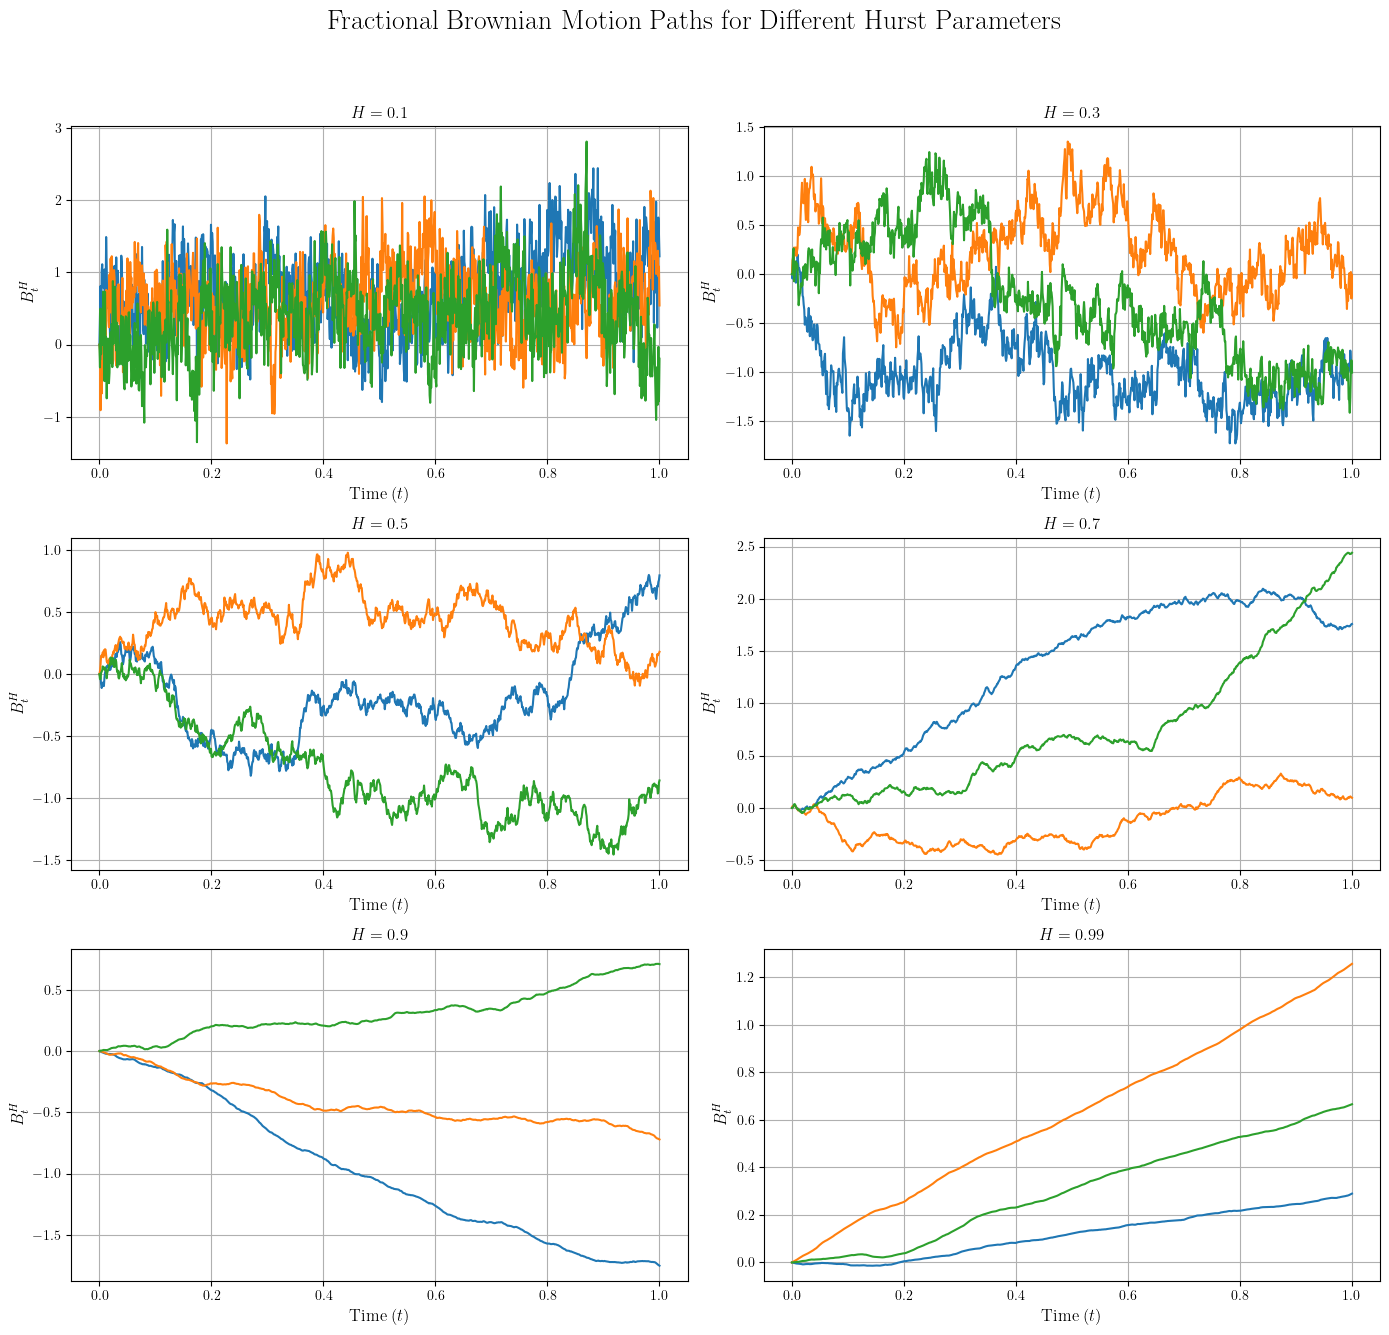

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_fbm(n, hurst, length=1, method='wood-chan'):
    """
    Simulates Fractional Brownian Motion (fBm) using the Wood-Chan method.

    This method is an exact simulation technique that first generates the
    increments of the fBm, known as fractional Gaussian noise (fGn),
    and then takes the cumulative sum to obtain the fBm path.
    It uses the Fast Fourier Transform (FFT).

    Args:
        n (int): The number of time points to generate in the final path.
        hurst (float): The Hurst parameter, must be in the interval (0, 1).
        length (float): The length of the time interval [0, T]. Defaults to 1.
        method (str): The simulation method. Currently, only 'wood-chan' is supported.

    Returns:
        tuple: A tuple containing:
            - t (np.array): The time vector of length n.
            - fbm_path (np.array): The simulated fBm path of length n.
    """
    
    if not 0 < hurst < 1:
        raise ValueError("Hurst parameter must be between 0 and 1.")
    if method != 'wood-chan':
        raise NotImplementedError("Only the 'wood-chan' method is supported.")


    # Step 1: Set up the sizes for the simulation
    # The Wood-Chan method requires the size of the circulant matrix (M) to be a power of 2
    # for maximal FFT efficiency.
    # We find the smallest power of 2 'q' such that 2**q is larger than n-1.
    q = int(np.ceil(np.log2(n - 1)))
    N = 2**q + 1  # Number of fGn increments to generate. Slightly larger than n.
    M = 2**(q + 1) # Size of the circulant matrix, chosen to be a power of 2.

    # Step 2: Calculate the autocovariance function of fGn and the first row 'c' of the circulant matrix
    def rho_H(k, H):
        """Autocovariance function for fractional Gaussian noise (fGn)."""
        if k == 0:
            return 1
        return 0.5 * (abs(k - 1)**(2 * H) - 2 * abs(k)**(2 * H) + abs(k + 1)**(2 * H))

    # Create the vector 'c', which is the first row of the embedding circulant matrix.
    c = np.zeros(M)
    for k in range(N):
        c[k] = rho_H(k, hurst)
    for k in range(N, M):
        # This completes the vector 'c' to make the resulting matrix circulant.
        # This is the symmetric completion from the original Wood-Chan algorithm.        
        c[k] = rho_H(M - k, hurst)
        
    # Step 3: Calculate the eigenvalues of the circulant matrix
    # The eigenvalues are obtained by taking the FFT of the first row 'c'.
    lambda_k = np.fft.fft(c).real # We use .real() to handle numerical errors.
    lambda_k[lambda_k < 0] = 0  # Avoid negative eigenvalues
    
    # Step 4: Generate uncorrelated random variables
    # These are the independent, standard Gaussian inputs to the simulation.
    zeta = np.random.randn(M)
    
    # Steps 5, 6, 7: Generate the fGn increments
    # This sequence of operations efficiently computes S*zeta = Q * Lambda^(1/2) * Q* * zeta,
    # where S is the square root of the circulant covariance matrix.

    # Step 5: Corresponds to (Q* zeta), where Q* is the inverse Fourier matrix.    
    zeta_ifft = np.fft.ifft(zeta)

    # Step 6: Corresponds to (Lambda^(1/2) * Q* zeta). Element-wise multiplication.
    term_mult = np.sqrt(lambda_k) * zeta_ifft

    # Step 7: Corresponds to Q * (Lambda^(1/2) * Q* zeta). This yields the fGn increments.
    fgn_M = np.fft.fft(term_mult).real

    # Step 8: Truncate the fGn sequence ---
    # We only need the first N increments for our simulation.
    fgn_N = fgn_M[:N]

    # Step 9: Scale the increments
    # The generated fGn has variance corresponding to a time step of 1.
    # We scale it to match the desired time interval length T (defined by 'length').
    # The scaling factor comes from the self-similarity property of fBm.
    # There are N points, so N-1 intervals in the generated path.
    scale_factor = (length / (N - 1))**hurst
    fbm_increments = scale_factor * fgn_N

    # Step 10: Create the fBm path via cumulative sum
    # Start the path at 0 (B_0 = 0) and then take the cumulative sum of increments.
    fbm_path_full = np.cumsum(np.insert(fbm_increments, 0, 0))
    fbm_path = fbm_path_full[:n] # Truncate the path to the originally requested number of points 'n'.
    t = np.linspace(0, length, n)
    
    return t, fbm_path

if __name__ == '__main__':
    # Simulation Parameters
    num_points = 1000  # The number of time points to generate for each path.
    hurst_params = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99] # A list of Hurst parameters to simulate and plot.
    num_paths_to_plot = 3 # The number of sample paths to generate for each Hurst parameter.


fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))
fig.suptitle(r'Fractional Brownian Motion Paths for Different Hurst Parameters', fontsize=20)
axes = axes.flatten()

# Loop over Hurst values and create plots
for i, H in enumerate(hurst_params):
    ax = axes[i]
    for _ in range(num_paths_to_plot):
        t, fbm = simulate_fbm(n=num_points, hurst=H)
        ax.plot(t, fbm)
    ax.set_title(fr'$H = {H}$')
    ax.set_xlabel(r'Time $(t)$')
    ax.set_ylabel(r'$B_t^H$')
    ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure at 1200 DPI
plt.savefig("fbm_simulation_2x3_layout_1200dpi.png", dpi=1200, bbox_inches='tight')
